In [ ]:
# ! pip install kaggle --quiet
# ! pip install kaggle --upgrade
# ! chmod 600 ~/.kaggle/kaggle.json 
# ! kaggle competitions download -c playground-series-s3e16

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans

In [16]:
# Создание экземпляра LabelEncoder для кодирования категориальных признаков
label_encoder = LabelEncoder()

# Указание пути к файлам данных и чтение тренировочных данных из CSV файла
folder_name = './s3e16/'
df = pd.read_csv(folder_name + 'train.csv')

# Чтение данных для предсказания из CSV файла
for_predict = pd.read_csv(folder_name + 'test.csv')

# Чтение образца представления данных для отправки из CSV файла
sample_submission = pd.read_csv(folder_name + 'sample_submission.csv')

# Удаление столбца 'id', так как он не несет смысловой нагрузки
df.drop(['id'], axis=1, inplace=True)

# Удаление дубликатов из тренировочных данных
df.drop_duplicates(inplace=True)

# Кодирование категориального признака 'Sex' с помощью LabelEncoder
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# функция переименования столбцов
def rename_columns(df):
    # Словарь для переименования столбцов
    new_column_name = {
        'Shucked Weight': 'Shucked_Weight',
        'Viscera Weight': 'Viscera_Weight',
        'Shell Weight': 'Shell_Weight'
    }
    # Переименование столбцов
    df.rename(columns=new_column_name, inplace=True)

# Переименование некоторых столбцов в тренировочных данных для удобства использования
rename_columns(df)

# Функция для создания новых признаков на основе существующих
def new_features(df):
    # Вычисление новых признаков
    df['Diameter_to_Length'] = (1 - (df['Diameter'] / df['Length'])) * 100
    df['Diameter_to_Length'] -= np.percentile(df['Diameter_to_Length'], 5)
    
    df['crab_volume'] = ((4/3) * math.pi * ((df['Diameter'] / 2) ** 2) * df['Height'])
    
    df['meat'] = np.sqrt((df['Weight'] - df['Shucked_Weight'] - df['Viscera_Weight'] - df['Shell_Weight']) ** 2 + 0.005)
    
    df['density'] = df['Weight'] / df['crab_volume']
    
    df['meat_to_density'] = ((df['meat'] / (df['density'] + 0.000001)) * 100).map(lambda x: round(x / 0.0002) * 0.0002)
    df['meat_to_density'] = df['meat_to_density'].rolling(window=2, min_periods=1).median()
    
    df['Height_to_Shell_Weight'] = (df['Height'] ** 2 / (np.sqrt(df['Shell_Weight']) + 0.000001)) * 100
    df['Height_to_Shell_Weight'] = df['Height_to_Shell_Weight'].rolling(window=2, min_periods=1).median()
    
    df['Meat'] = df['Shucked_Weight'] / (df['Weight'] + df['Shell_Weight'])
    df['Meat'] = (df['Meat'] - df['Meat'].mean()) * 100
    
    df['shell_ratio'] = ((df['Shell_Weight'] / df['Weight']) - df['shell_ratio'].median()) * 100
    
    df['Weight'] -= df['Weight'].median()
    df['Weight'] **= 3
    df['Weight'] **= 2
    df['Weight'] /= 10
    df['Weight'] /= 100
    df['Shell_Weight'] -= df['Shell_Weight'].median()
    df['Shell_Weight'] **= 2
    
    df['density'] /= 100
    
    return df

# Функция для обнаружения выбросов в данных
def detect_outliers(column):
    # Вычисление границ выбросов методом межквартильного размаха
    Q1 = df[column].quantile(0.08)
    Q3 = df[column].quantile(0.92)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # Создание маски для выбросов
    outliers_mask = df.query(f'{column} < {lower} or {column} > {upper}').copy()
    # Удаление строк с выбросами
    df.drop(outliers_mask.index, inplace=True)
    
# Генерация кластерных меток на основе выбранных признаков
def cluster_labels(df, n_clusters=28, columns=['Sex','meat_to_density', 'Weight']):
    # Копирование данных
    X_df = df.copy()
    # Создание объекта KMeans для кластеризации
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=42)
    # Предсказание меток кластеров
    X_new = pd.DataFrame()
    X_new['Cluster'] = kmeans.fit_predict(X_df[columns])

    return X_new

# Создание новых признаков на основе существующих
df = new_features(df)

# Обнаружение и удаление выбросов в данных
for col in df.columns.drop(['Age', 'Sex']):
    detect_outliers(col)

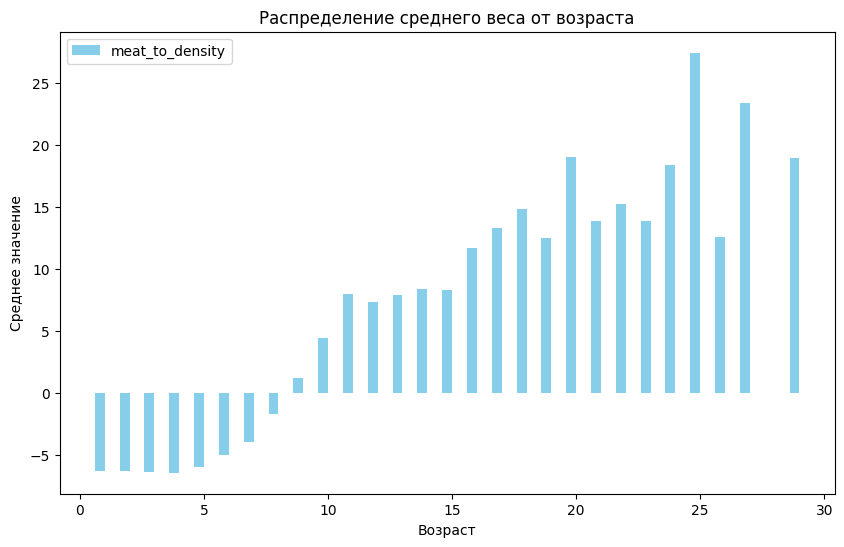

In [3]:
# Группировка данных по возрасту и вычисление среднего значения для каждого столбца
age_groups_meat_to_density = df.groupby('Age')['meat_to_density'].mean()

# Создание нового графика
plt.figure(figsize=(10, 6))

# Построение столбчатой гистограммы для 'meat_to_density'
plt.bar(age_groups_meat_to_density.index - 0.2, age_groups_meat_to_density.values, width=0.4, color='skyblue', label='meat_to_density')

# Добавление названия графика и подписей осей
plt.title('Распределение среднего веса от возраста')
plt.xlabel('Возраст')
plt.ylabel('Среднее значение')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

In [17]:
# Удаление строк с пропущенными значениями и определение признаков и целевой переменной
drop = ['Viscera_Weight','Height','Shucked_Weight','crab_volume','Diameter']
def preprocess_data(df, drop):
    # Удаление строк с пропущенными значениями
    df.dropna(inplace=True)
    
    # Определение признаков и целевой переменной
    X = df.drop(columns=drop).copy()
    X.drop(columns='Age', inplace=True)
    y = df['Age'].copy()
    
    return X, y

# Вычисление корреляционной матрицы признаков и значений мультиколлинеарности (VIF)
def calculate_vif(X):
    df_corr = X.corr()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_corr.columns
    vif_data["VIF"] = [variance_inflation_factor(df_corr.values, i) for i in range(len(df_corr.columns))]
    return vif_data

# Предварительная обработка данных
X, y = preprocess_data(df, drop)
# Вычисление VIF
vif_data = calculate_vif(X)
print(vif_data)

                   Feature        VIF
0                      Sex   1.015892
1                   Length  36.034560
2                   Weight   4.707650
3             Shell_Weight  21.308914
4       Diameter_to_Length   3.777269
5                     meat  42.129421
6                  density   9.562353
7          meat_to_density  17.294837
8   Height_to_Shell_Weight  12.007303
9                     Meat  11.064878
10             shell_ratio  13.696688


In [5]:
# Кластеризация данных и добавление меток кластеров в датасет
X['Cluster'] = cluster_labels(X)
# Удаление строк с пропущенными значениями после кластеризации
nan_indices = X[X.isna().any(axis=1)].index
X.drop(index=nan_indices, inplace=True)
y.drop(index=nan_indices, inplace=True)

In [18]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели LGBMRegressor
lgbm = LGBMRegressor(objective='mae')

# Определение параметров для случайного поиска
cv = 2
iter = 40
n_est = 20

lgbm_params =  {
    'num_leaves': range (2, 30, 1),
    'max_depth': range (3, 50, 1),
    'subsample': np.arange (0.8, 1, 0.05),
    'learning_rate': np.arange (0.001, 0.4, 0.001),
    'n_estimators': range (5, 25, 2), 
    'colsample_bytree': np.arange (0.3, 1, 0.005),
    'reg_alpha': np.arange (0, 0.51, 0.001),
    'min_child_samples': range (1, 13, 2)
}

randomized_lgbm = RandomizedSearchCV(
    lgbm, 
    param_distributions = lgbm_params,
    scoring = 'neg_mean_absolute_error',
    cv = cv,
    n_jobs = -1,
    return_train_score = False,
    n_iter=iter
)

lgbm_bag = BaggingRegressor (estimator=randomized_lgbm, n_estimators=n_est).fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 28357, number of used features: 11
[LightGBM] [Info] Start training from score 9.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2417
[LightGBM] [Info] Number of data points in the train set: 28358, number of used features: 11
[LightGBM] [Info] Start training from score 9.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set

In [19]:
# Вывод итогового значения MAE для модели lgbm_bag
print ('Итоговое значение MAE lgbm_bag',mean_absolute_error (y_test, lgbm_bag.predict (X_test)))

Итоговое значение MAE lgbm_bag 1.3573172073619393


In [14]:
# Чтение данных для предсказания из CSV файла
for_predict = pd.read_csv(folder_name + 'test.csv')

# Получение идентификаторов из тестового набора данных
id = for_predict['id']

# Удаление столбца 'id' из данных для предсказания
for_predict.drop(columns=['id'], inplace=True)

# Кодирование категориального признака 'Sex' с помощью LabelEncoder
for_predict['Sex'] = label_encoder.fit_transform(for_predict['Sex'])

# Переименование некоторых столбцов в данных для предсказания для удобства использования
rename_columns(for_predict)

# Применение функции для создания новых признаков к данным для предсказания и удаление ненужных признаков
df_to_predict = new_features(for_predict).drop(columns=drop, inplace=False)

# Кластеризация данных для предсказания и добавление меток кластеров
df_to_predict['Cluster'] = cluster_labels(df_to_predict)

# Предсказание возраста с помощью обученной модели lgbm_bag
predicted_lgbm_bag = lgbm_bag.predict(df_to_predict)

# Создание DataFrame с предсказанными значениями и соответствующими идентификаторами
solution = pd.DataFrame({
    'id': id,
    'Age': np.round(predicted_lgbm_bag, 0)
})

# Сохранение результата в CSV файл
solution.to_csv('solution.csv', index=False)
! kaggle competitions submit -c playground-series-s3e16 -f solution.csv -m '_'
     

/tmp/ipykernel_3284/3519516881.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['meat_to_density'].loc[0] = loc_mtd
/tmp/ipykernel_3284/3519516881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

100%|█████████████████████████████████████████| 531k/531k [00:01<00:00, 274kB/s]
Successfully submitted to Regression with a Crab Age Dataset